In [ ]:
## @meermehran -- M3RG Lab -- Indian Institute of Technology, Delhi
## @date : 28Sept2022

####################################--DESCRIPTION####################################################
##                                                                                                 ##
## -----------------------------Benchmarking- FNO-v-ResNet-UNet----------------------------------- ##
##                                                                                                 ##        
#####################################################################################################

In [1]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from Adam import Adam
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
import scipy.io as sio

from timeit import default_timer
from utility import *

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)
np.random.seed(0)


## STRAIN

#### MODEL-RESNET

In [2]:



class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        
        
        identity = x.clone()

        x = self.relu(self.batch_norm2(self.conv1(x)))
        x = self.batch_norm2(self.conv2(x))

        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        print(x.shape)
        print(identity.shape)
        x += identity
        x = self.relu(x)
        return x


        
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

In [3]:
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)

In [54]:
######################################################
### Data Loading
######################################################


X_Data = '/DATA1/meer/data/material-v3-3350.mat'
Y_Data = '/DATA1/meer/data/strain-v3-3350.mat'

ntrain =1200
ntest = 200
batch_size =20
dim = 48
strain_channels = 3


################################################################
# load data and data normalization
################################################################

reader = MatReader(X_Data)   
x_train = reader.read_field('Emat')[:ntrain]
x_test = reader.read_field('Emat')[-ntest:]
x_test_plot = reader.read_field('Emat')[-ntest:]


reader.load_file(Y_Data) 
y_train = reader.read_field('strain')[:ntrain]#    
y_test_strain = reader.read_field('strain')[-ntest:] 


######################################################
### Normalization
######################################################

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)



train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test_strain), batch_size=batch_size, shuffle=False)



if device=='cpu':
    y_normalizer.cpu()
else:
    y_normalizer.cuda()


In [55]:
print(f' x_train Shape := {x_train.shape}')
print(f' y_train Shape := {y_train.shape}')
print(f' x_test Shape := {x_test.shape}')
print(f' y_test_strain Shape := {y_test_strain.shape}')


 x_train Shape := torch.Size([1200, 48, 48])
 y_train Shape := torch.Size([1200, 48, 48, 3])
 x_test Shape := torch.Size([200, 48, 48])
 y_test_strain Shape := torch.Size([200, 48, 48, 3])


In [56]:
# ################################################################
## Model
# ################################################################

model = ResNet50(48*48*3, 1).to(device)
print(f'MODEL PARAMETERS. :== {count_params(model)}')
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= 1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)  ### gamma =0.1
epochs = 500
print('\n')
      
print(f'Epochs:= {epochs}--- LR:={learning_rate}---BatchSize:= {batch_size}')

MODEL PARAMETERS. :== 37690944


Epochs:= 500--- LR:=0.001---BatchSize:= 20


In [57]:

trainerror=[] 
testerror=[]

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        x =x.reshape(x.shape[0], 1, dim, dim)

        optimizer.zero_grad()

        out = model(x).reshape(batch_size, dim, dim,strain_channels)

        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)
        
        

        loss = lossfunc(y.view(batch_size,-1),out.view(batch_size,-1))
  
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            x =x.reshape(x.shape[0], 1, dim, dim)
            out = model(x).reshape(batch_size, dim, dim,strain_channels)
            out = y_normalizer.decode(out)

            test_l2 += lossfunc(y.view(batch_size,-1),out.view(batch_size,-1)).item()

    train_l2/= ntrain
    test_l2 /= ntest
    trainerror += [train_l2]
    testerror += [test_l2]
    t2 = default_timer()
    print(f' Epoch :== {ep+1}  ||  TIME(sec):== {np.round((t2-t1),4)} '
          f'|| TrainError:== {np.round(train_l2,6)}  ||  TestError:== {np.round(test_l2,6)}')

 Epoch :== 1  ||  TIME(sec):== 3.4079 || TrainError:== 0.750091  ||  TestError:== 0.721206
 Epoch :== 2  ||  TIME(sec):== 3.2972 || TrainError:== 0.707028  ||  TestError:== 0.704414
 Epoch :== 3  ||  TIME(sec):== 3.2882 || TrainError:== 0.694609  ||  TestError:== 0.690228
 Epoch :== 4  ||  TIME(sec):== 3.3245 || TrainError:== 0.683731  ||  TestError:== 0.685511
 Epoch :== 5  ||  TIME(sec):== 3.3254 || TrainError:== 0.656809  ||  TestError:== 0.638899
 Epoch :== 6  ||  TIME(sec):== 3.3021 || TrainError:== 0.616193  ||  TestError:== 0.585048
 Epoch :== 7  ||  TIME(sec):== 3.3377 || TrainError:== 0.586579  ||  TestError:== 1.483794
 Epoch :== 8  ||  TIME(sec):== 3.2883 || TrainError:== 0.560886  ||  TestError:== 0.59791
 Epoch :== 9  ||  TIME(sec):== 3.3141 || TrainError:== 0.510134  ||  TestError:== 0.538751
 Epoch :== 10  ||  TIME(sec):== 3.2909 || TrainError:== 0.478582  ||  TestError:== 0.465638
 Epoch :== 11  ||  TIME(sec):== 3.3054 || TrainError:== 0.436024  ||  TestError:== 0.42034

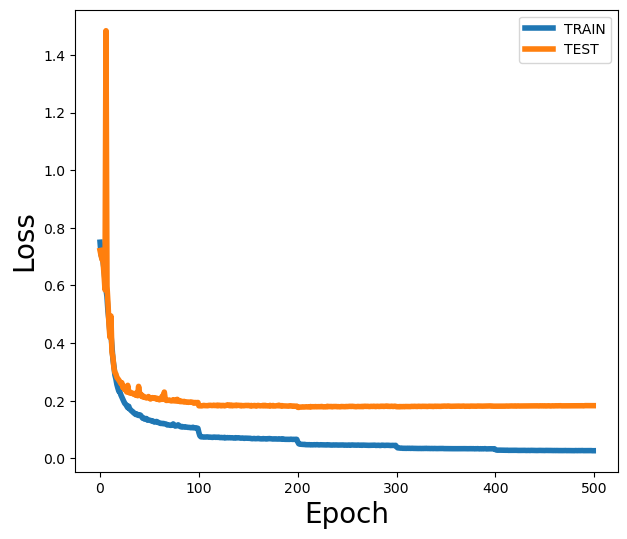

In [58]:
plt.figure(figsize=(7,6))
plt.plot(range(epochs),trainerror,linewidth = 4,label ="TRAIN")
plt.plot(range(epochs),testerror, linewidth = 4,label ="TEST")
plt.xlabel('Epoch', fontsize =20)
plt.ylabel('Loss', fontsize =20)
plt.legend()
plt.show()

In [23]:
# trainn = np.array(trainerror)
# testnn = np.array(testerror)
# torch.save(model.state_dict(),'ResNet_STAIN_N1200_ep1200.pt')
# np.save('trainResNet_STRAIN', trainn)
# np.save('testResNet_STRAIN', testnn)

In [33]:
# path = 'ResNet_STRAIN_N1200_ep1200.pt'
# model.load_state_dict(torch.load(path))
# print(model)

#### Testing-STRAINS

In [59]:
prediction = torch.zeros(y_test_strain.shape)
c = 0
with torch.no_grad():
    for x,y in test_loader:
        x, y = x.to(device), y.to(device)
        x =x.reshape(x.shape[0], 1, dim, dim)
        out = model(x).reshape(batch_size, dim, dim,3)
        out = y_normalizer.decode(out)
        prediction[c*batch_size :c*batch_size+batch_size] = out
        c+=1
        
        

In [60]:
strain_act = y_test_strain.reshape(ntest, -1)
strain_pred = prediction.reshape(ntest,-1)



In [61]:
r2_strain =[]
for i in range(strain_act.shape[0]):
    act = strain_act[i]
    pred = strain_pred[i]

    r2 = r2_score(act,pred)

    r2_strain += [r2]

### METRIC Evaluation

In [62]:
r2_avg_strain = np.average(r2_strain)
r2_std_strain = np.std(r2_strain)

print(r2_avg_strain,r2_std_strain)

0.9590832453346982 0.03296087252346871


In [63]:
## R2 mean and std
print(np.round((r2_avg_strain),2))
print(np.round((r2_std_strain),2))

0.96
0.03


In [64]:
## total test loss

loss = lossfunc(y_test_strain, prediction)
print(loss/ntest)

tensor(0.1830)


## STRESS

In [4]:
######################################################
### Data Loading & Hyperparameters
######################################################


X_Data = '/DATA1/meer/data/material-v3-3350.mat'
Y_Data = '/DATA1/meer/data/stress-v3-3350.mat'


ntrain =1200
ntest = 200
batch_size =20


################################################################
# load data and data normalization
################################################################

reader = MatReader(X_Data)   
x_train = reader.read_field('Emat')[:ntrain]
x_test = reader.read_field('Emat')[-ntest:]
x_test_plot = reader.read_field('Emat')[-ntest:]

reader.load_file(Y_Data) 
y_train = reader.read_field('stress')[:ntrain]#   
y_test_stress = reader.read_field('stress')[-ntest:]   

######################################################
### Normalization
######################################################

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)


train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test_stress), batch_size=batch_size, shuffle=False)



if device=='cpu':
    y_normalizer.cpu()
else:
    y_normalizer.cuda()


In [5]:
print(f' x_train Shape := {x_train.shape}')
print(f' y_train Shape := {y_train.shape}')
print(f' x_test Shape := {x_test.shape}')
print(f' y_test_stress Shape := {y_test_stress.shape}')

 x_train Shape := torch.Size([1200, 48, 48])
 y_train Shape := torch.Size([1200, 48, 48, 3])
 x_test Shape := torch.Size([200, 48, 48])
 y_test_stress Shape := torch.Size([200, 48, 48, 3])


In [6]:
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)

In [7]:
# ################################################################
## Model
# ################################################################

model = ResNet50(48*48*3, 1).to(device)
print(f'MODEL PARAMETERS. :== {count_params(model)}')
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= 1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)  ### gamma =0.1
epochs = 500
print('\n')
      
print(f'Epochs:= {epochs}--- LR:={learning_rate}---BatchSize:= {batch_size}')

MODEL PARAMETERS. :== 37690944


Epochs:= 500--- LR:=0.001---BatchSize:= 20


In [8]:

trainerror=[] 
testerror=[]
dim =48
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        x =x.reshape(x.shape[0], 1, dim, dim)

        optimizer.zero_grad()

        out = model(x).reshape(batch_size, dim, dim,3)

        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)
        
        

        loss = lossfunc(y.view(batch_size,-1),out.view(batch_size,-1))
  
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            x =x.reshape(x.shape[0], 1, dim, dim)
            out = model(x).reshape(batch_size, dim, dim,3)
            out = y_normalizer.decode(out)

            test_l2 += lossfunc(y.view(batch_size,-1),out.view(batch_size,-1)).item()

    train_l2/= ntrain
    test_l2 /= ntest
    trainerror += [train_l2]
    testerror += [test_l2]
    t2 = default_timer()
    print(f' Epoch :== {ep+1}  ||  TIME(sec):== {np.round((t2-t1),4)} '
          f'|| TrainError:== {np.round(train_l2,6)}  ||  TestError:== {np.round(test_l2,6)}')

 Epoch :== 1  ||  TIME(sec):== 6.3711 || TrainError:== 0.563467  ||  TestError:== 0.531812
 Epoch :== 2  ||  TIME(sec):== 3.1854 || TrainError:== 0.526763  ||  TestError:== 0.526905
 Epoch :== 3  ||  TIME(sec):== 3.1606 || TrainError:== 0.522204  ||  TestError:== 0.527631
 Epoch :== 4  ||  TIME(sec):== 3.1532 || TrainError:== 0.517538  ||  TestError:== 0.517654
 Epoch :== 5  ||  TIME(sec):== 3.1433 || TrainError:== 0.507306  ||  TestError:== 0.499562
 Epoch :== 6  ||  TIME(sec):== 3.1301 || TrainError:== 0.466186  ||  TestError:== 0.439761
 Epoch :== 7  ||  TIME(sec):== 3.1752 || TrainError:== 0.428133  ||  TestError:== 0.477868
 Epoch :== 8  ||  TIME(sec):== 3.173 || TrainError:== 0.382711  ||  TestError:== 0.432242
 Epoch :== 9  ||  TIME(sec):== 3.1462 || TrainError:== 0.356736  ||  TestError:== 0.360367
 Epoch :== 10  ||  TIME(sec):== 3.1365 || TrainError:== 0.328501  ||  TestError:== 0.322819
 Epoch :== 11  ||  TIME(sec):== 3.2037 || TrainError:== 0.310847  ||  TestError:== 0.30370

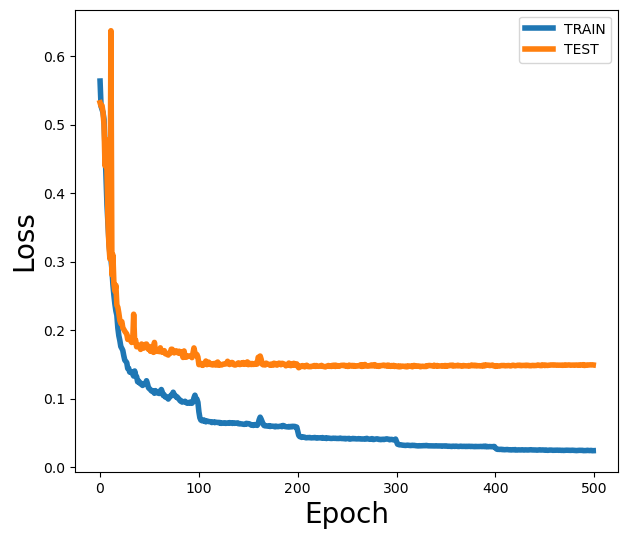

In [9]:
plt.figure(figsize=(7,6))
plt.plot(range(epochs),trainerror,linewidth = 4,label ="TRAIN")
plt.plot(range(epochs),testerror, linewidth = 4,label ="TEST")
plt.xlabel('Epoch', fontsize =20)
plt.ylabel('Loss', fontsize =20)
plt.legend()
plt.show()

In [10]:
# trainn = np.array(trainerror)
# testnn = np.array(testerror)
# torch.save(model.state_dict(),'ResNet_STRESS_N1200_ep1200.pt')
# np.save('trainResNetStress', trainn)
# np.save('testResNetStress', testnn)

#### Testing-Stress

In [11]:
prediction = torch.zeros(y_test_stress.shape)
c = 0
with torch.no_grad():
    for x,y in test_loader:
        x, y = x.to(device), y.to(device)
        x =x.reshape(x.shape[0], 1, dim, dim)
        
        out = model(x).reshape(batch_size, dim, dim,3)
        out = y_normalizer.decode(out)
        prediction[c*batch_size :c*batch_size+batch_size] = out
        c+=1
        
        

In [12]:
stress_act = y_test_stress.reshape(ntest, -1)
stress_pred = prediction.reshape(ntest,-1)

r2_stress =[]
for i in range(stress_act.shape[0]):
    act = stress_act[i]
    pred = stress_pred[i]
    r2 = r2_score(act,pred)
    r2_stress += [r2]

In [13]:
r2_avg_stress = np.average(r2_stress)
r2_std_stress = np.std(r2_stress)

print(r2_avg_stress,r2_std_stress)

0.9577617246632376 0.06755535441836907


In [14]:
print(np.round((r2_avg_stress),2))
print(np.round((r2_std_stress),2))

0.96
0.07


In [15]:

## total test loss
loss = lossfunc(y_test_stress, prediction)
print(loss/ntest)

tensor(0.1491)
